# Kaggle Regression



### Libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
from scipy.signal import butter, filtfilt

from utility import read_all_csvs_one_test
from utility import run_cv_one_motor
from utility import read_all_test_data_from_path
from utility import read_all_test_data_from_path, show_reg_result,extract_selected_feature, prepare_sliding_window, FaultDetectReg

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_regression
from functions import *
from sklearn.ensemble import GradientBoostingRegressor


## Read data and pre_processing

In [2]:
utility_path = '../'
sys.path.insert(1, utility_path)


n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    # Function to design a Butterworth low-pass filter
    def butter_lowpass(cutoff, fs, order=5):
        nyquist = 0.8 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a


    # Function to apply the Butterworth low-pass filter
    def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
        b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
        filtered_data = filtfilt(b, a, data)
        return filtered_data


    # Set parameters for the low-pass filter
    cutoff_frequency = 1  # Adjust as needed
    sampling_frequency = 10  # Assuming your data is evenly spaced in time


    def customized_outlier_removal(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].ffill()
        df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
        df['position'] = df['position'].rolling(window=20, min_periods=1).mean()
        df['position'] = df['position'].round()

        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].rolling(window=20, min_periods=1).mean()

        # Make sure that the difference between the current and previous temperature cannot be too large.
        # Define your threshold
        threshold = 1
        # Shift the 'temperature' column by one row to get the previous temperature
        prev_tmp = df['temperature'].shift(1)
        # Calculate the absolute difference between current and previous temperature
        temp_diff = np.abs(df['temperature'] - prev_tmp)
        # Set the temperature to NaN where the difference is larger than the threshold
        df.loc[temp_diff > threshold, 'temperature'] = np.nan
        df['temperature'] = df['temperature'].ffill()

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
        df['voltage'] = df['voltage'].ffill()
        df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
        df['voltage'] = df['voltage'].rolling(window=20, min_periods=1).mean()  
        
    def remove_seq_variability(df: pd.DataFrame):
        ''' # Description
        Remove the sequence-to-sequence variability.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

    # Start processing.
    customized_outlier_removal(df)
    remove_seq_variability(df)

# Ignore warnings.
warnings.filterwarnings('ignore')

base_dictionary = '../../dataset/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [3]:
# Pre-train the model.
# Get all the normal data
normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_163963',
    '20240503_164435',
    '20240503_164675',
    '20240503_165189'
]


### After collect data : 

normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_163963',
    '20240503_164435',
    '20240503_164675',
    '20240503_165189',
    '20240529_122361',
    '20240529_122994',
    '20240529_123223',
    '20240529_123430',
    '20240529_124333',
    '20240529_125896',
    '20240529_130680',
    '20240529_131085',
    '20240529_131373',
    '20240529_131558',
    '20240529_131755',
    '20240529_132509',
    '20240529_133879'
]



df_experiment = df_train[df_train['test_condition'].isin(normal_test_id)]

### Testing data.

In [4]:
# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# EDA

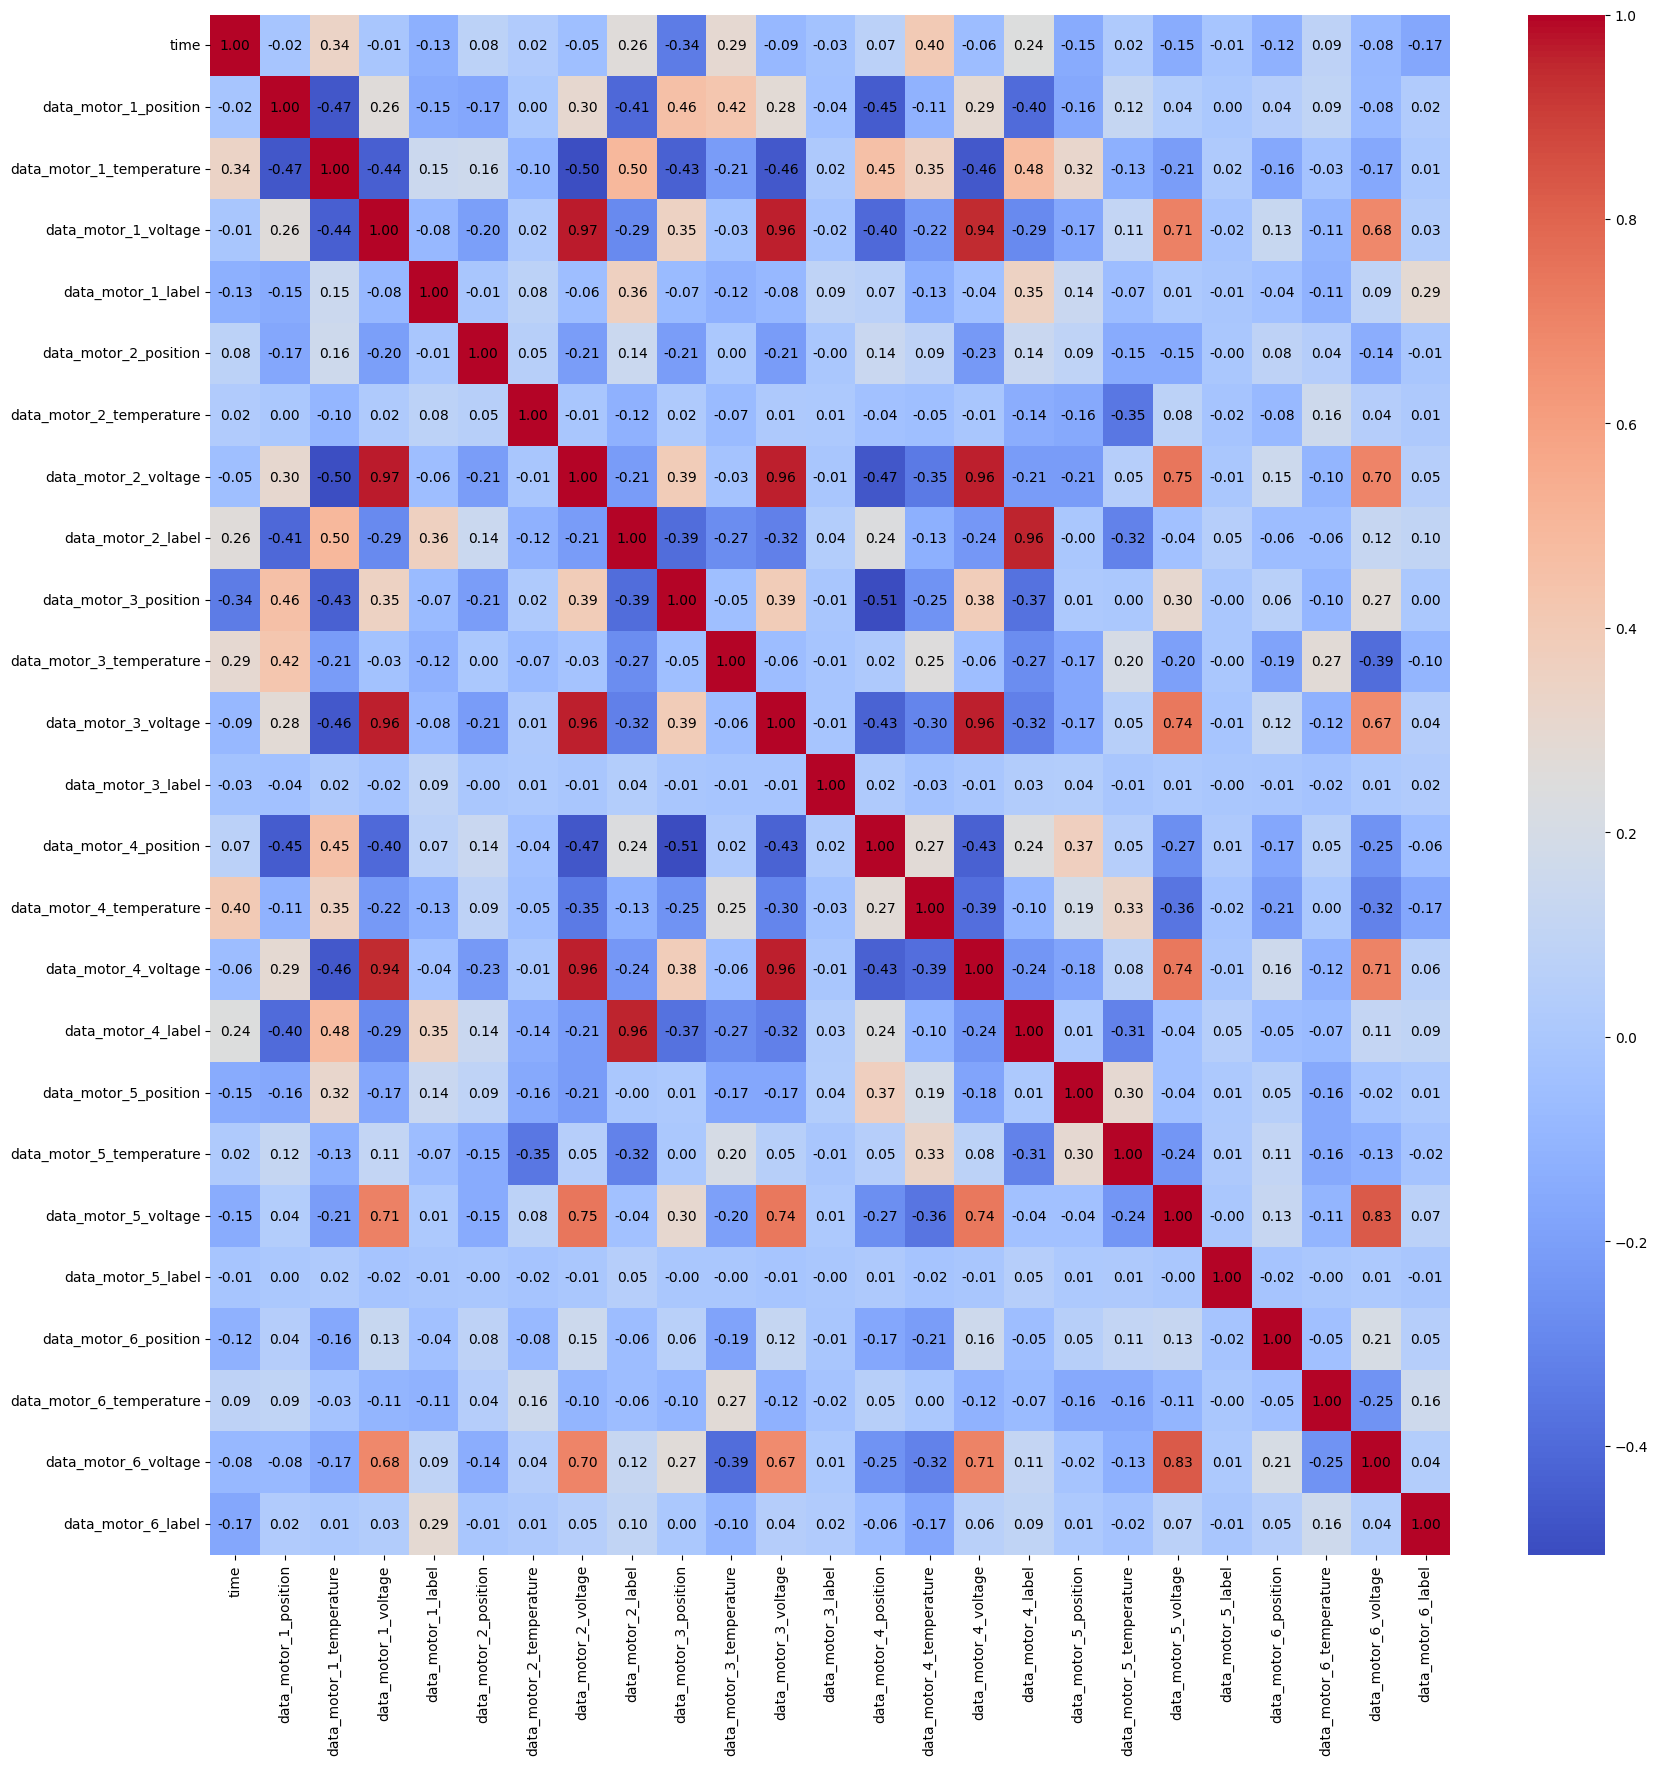

In [16]:
# Compute correlation matrix
correlation_matrix = df_train.iloc[:,:-1].corr()

# Plot correlation matrix using seaborn
plt.figure(figsize=(20, 20))  # Adjust width and height as needed
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j + 0.5, i + 0.5, '{:.2f}'.format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='black')


# Training the regression model.

In [7]:
def run_all_motors_validation(motor_label, drop_list):
    feature_list_all = df_experiment.drop(columns=drop_list + ["test_condition"] + label_columns).columns.tolist()

    # Prepare feature and response of the training dataset.
    x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_experiment, feature_list=feature_list_all, motor_idx=motor_label, mdl_type='reg')

    # Enrich the features based on the sliding window.
    window_size = 100
    sample_step = 50
    prediction_lead_time = 1 
    threshold = 0.8
    abnormal_limit = 2

    x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')
    
    warnings.filterwarnings('ignore')
    
    # Initialize models
    #models = {
    #    'Linear Regression': LinearRegression(),
    #    'Ridge Regression': Ridge(),
    #    'Lasso Regression': Lasso(),
    #    'ElasticNet Regression': ElasticNet(),
    #    'Decision Tree Regression': DecisionTreeRegressor(),
    #    'Gradient Boosting Regressor' : GradientBoostingRegressor()
    #}
    
    models = {
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge()
    }
    
    #param_grids = {
        #'Linear Regression': {'n_jobs':[-1]},  
        #'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
        #'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
        #'ElasticNet Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.001, 0.01, 0.1, 1, 10]}, 
        #'Decision Tree Regression': {},
        #'Gradient Boosting Regressor' : {'learning_rate': [0.01], 'subsample' : [0.9],'n_estimators' : [100]}
    #}
    
    param_grids = {
        'Lasso Regression': {'alpha': [0.001]},
        'Ridge Regression': {'alpha': [0.001]}
    }
    
    model_predictions = {}
    best_params = {}
    
    # Perform cross-validation, hyperparameter tuning, and evaluation
    for model_name, model in models.items():
        
        pipeline = Pipeline([
            #('scaler', MinMaxScaler()), # Step 1 : Normalization
            ('scaler', StandardScaler()), # Step 1 : Normalization
            ('model', model)
        ])
        param_grid = {f'model__{key}': value for key, value in param_grids[model_name].items()}
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(x_tr, y_temp_tr)
        mdl = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_
        
        # Define the fault detector.
        detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)
        
        # Prepare the testing data.
        x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=motor_label, mdl_type='reg')
        
        
        # Make predicition.
        y_pred, y_response_test_pred = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org, complement_truncation=True)
        
        model_predictions[f'y_pred_{model_name.replace(" ", "_")}'] = y_pred 
    
    return model_predictions, best_params


# Motor 1

In [8]:
#Feature Selection

drop_list1_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']

drop_list1_label1 = ['data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list2_label1 = []

model_predictions, best_params1 = run_all_motors_validation(1, drop_list1_label1)
#model_predictions, best_params1 = run_all_motors_validation(1, drop_list2_label1)
#y_pred1_Linear_Regression = model_predictions['y_pred_Linear_Regression']
y_pred1_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred1_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred1_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred1_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred1_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


In [29]:
best_params1

{'Lasso Regression': {'model__alpha': 0.01}}

# Motor 2

In [9]:
# Feature Selection

drop_list1_label2 = ['data_motor_1_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_5_temperature']

drop_list1_label2 = ['data_motor_1_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list2_label2 = []

model_predictions, best_params2 = run_all_motors_validation(2, drop_list1_label2)
#model_predictions, best_params2 = run_all_motors_validation(2, drop_list2_label2)

#y_pred2_Linear_Regression = model_predictions['y_pred_Linear_Regression']
y_pred2_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred2_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred2_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred2_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred2_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


In [12]:
best_params2

{'Lasso Regression': {'model__alpha': 0.0001}}

# Motor 3

In [10]:

# Feature Selection

drop_list1_label3 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']
drop_list1_label3 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']
drop_list2_label3 = []

model_predictions, best_params3 = run_all_motors_validation(3, drop_list1_label3)
#model_predictions, best_params3 = run_all_motors_validation(3, drop_list2_label3)
#y_pred3_Linear_Regression = model_predictions['y_pred_Linear_Regression']
y_pred3_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred3_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred3_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred3_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred3_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


In [14]:
best_params3

{'Lasso Regression': {'model__alpha': 0.0001}}

# Motor 4

In [11]:
# Feature Selection

drop_list1_label4= ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage','data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_5_temperature']

drop_list1_label4 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list2_label4 = []

model_predictions,best_params4 = run_all_motors_validation(4, drop_list1_label4)
#model_predictions,best_params4 = run_all_motors_validation(4, drop_list2_label4)

#y_pred4_Linear_Regression = model_predictions['y_pred_Linear_Regression']
y_pred4_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred4_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred4_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred4_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred4_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


In [16]:
best_params4

{'Lasso Regression': {'model__alpha': 0.0001}}

# Motor 5

In [12]:

#Feature Selection

drop_list1_label5 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_6_voltage']

drop_list1_label5 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_6_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list2_label5 = []


model_predictions,best_params5 = run_all_motors_validation(5, drop_list1_label5)
#model_predictions,best_params5 = run_all_motors_validation(5, drop_list2_label5)

#y_pred5_Linear_Regression = model_predictions['y_pred_Linear_Regression']
y_pred5_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred5_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred5_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred5_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred5_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


In [18]:
best_params5

{'Lasso Regression': {'model__alpha': 0.0001}}

# Motor 6

In [13]:
#Feature Selection

drop_list1_label6 = ['data_motor_1_voltage','data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_position']


drop_list1_label6 = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage', 'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_1_position','data_motor_5_position','data_motor_6_position', 'data_motor_1_temperature','data_motor_2_temperature','data_motor_4_temperature', 'data_motor_5_temperature']

drop_list2_label6 = []

model_predictions,best_params6 = run_all_motors_validation(6, drop_list1_label6)

#model_predictions,best_params6 = run_all_motors_validation(6, drop_list2_label6)

#y_pred6_Linear_Regression = model_predictions['y_pred_Linear_Regression']
y_pred6_Ridge_Regression = model_predictions['y_pred_Ridge_Regression']
y_pred6_Lasso_Regression = model_predictions['y_pred_Lasso_Regression']
#y_pred6_ElasticNet_Regression= model_predictions['y_pred_ElasticNet_Regression']
#y_pred6_Decision_Tree_Regression= model_predictions['y_pred_Decision_Tree_Regression']
#y_pred6_Gradient_Boosting_Regressor= model_predictions['y_pred_Gradient_Boosting_Regressor']

100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


In [20]:
best_params6

{'Lasso Regression': {'model__alpha': 0.0001}}

## Create csv file for submit Prediction

Linear_Regression

In [76]:
data_Linear_Regression = {
    'idx': range(len(y_pred1_Linear_Regression)),
    'data_motor_1_label': y_pred1_Linear_Regression,
    'data_motor_2_label': y_pred2_Linear_Regression,
    'data_motor_3_label': y_pred3_Linear_Regression,
    'data_motor_4_label': y_pred4_Linear_Regression,
    'data_motor_5_label': y_pred5_Linear_Regression,
    'data_motor_6_label': y_pred6_Linear_Regression
}

df_Linear_Regression = pd.DataFrame(data_Linear_Regression)

df_Linear_Regression.to_csv('motor_predictions_Linear_Regression.csv', index=False)

Ridge_Regression

In [14]:
data_Ridge_Regression = {
    'idx': range(len(y_pred1_Ridge_Regression)),
    'data_motor_1_label': y_pred1_Ridge_Regression,
    'data_motor_2_label': y_pred2_Ridge_Regression,
    'data_motor_3_label': y_pred3_Ridge_Regression,
    'data_motor_4_label': y_pred4_Ridge_Regression,
    'data_motor_5_label': y_pred5_Ridge_Regression,
    'data_motor_6_label': y_pred6_Ridge_Regression
}

df_Ridge_Regression = pd.DataFrame(data_Ridge_Regression)

df_Ridge_Regression.to_csv('motor_predictions_Ridge_Regression.csv', index=False)

Lasso_Regression

In [15]:
data_Lasso_Regression = {
    'idx': range(len(y_pred1_Lasso_Regression)),
    'data_motor_1_label': y_pred1_Lasso_Regression,
    'data_motor_2_label': y_pred2_Lasso_Regression,
    'data_motor_3_label': y_pred3_Lasso_Regression,
    'data_motor_4_label': y_pred4_Lasso_Regression,
    'data_motor_5_label': y_pred5_Lasso_Regression,
    'data_motor_6_label': y_pred6_Lasso_Regression
}

df_Lasso_Regression = pd.DataFrame(data_Lasso_Regression)

df_Lasso_Regression.to_csv('motor_predictions_Lasso_Regression.csv', index=False)

ElasticNet_Regression

In [79]:
data_ElasticNet_Regression = {
    'idx': range(len(y_pred1_ElasticNet_Regression)),
    'data_motor_1_label': y_pred1_ElasticNet_Regression,
    'data_motor_2_label': y_pred2_ElasticNet_Regression,
    'data_motor_3_label': y_pred3_ElasticNet_Regression,
    'data_motor_4_label': y_pred4_ElasticNet_Regression,
    'data_motor_5_label': y_pred5_ElasticNet_Regression,
    'data_motor_6_label': y_pred6_ElasticNet_Regression
}

df_ElasticNet_Regression = pd.DataFrame(data_ElasticNet_Regression)

df_ElasticNet_Regression.to_csv('motor_predictions_ElasticNet_Regression.csv', index=False)

Decision_Tree_Regression

In [24]:
data_Decision_Tree_Regression = {
    'idx': range(len(y_pred1_Decision_Tree_Regression)),
    'data_motor_1_label': y_pred1_Decision_Tree_Regression,
    'data_motor_2_label': y_pred2_Decision_Tree_Regression,
    'data_motor_3_label': y_pred3_Decision_Tree_Regression,
    'data_motor_4_label': y_pred4_Decision_Tree_Regression,
    'data_motor_5_label': y_pred5_Decision_Tree_Regression,
    'data_motor_6_label': y_pred6_Decision_Tree_Regression
}

df_Decision_Tree_Regression = pd.DataFrame(data_Decision_Tree_Regression)

df_Decision_Tree_Regression.to_csv('motor_predictions_Decision_Tree_Regression.csv', index=False)

Gradient_Boosting_Regressor

In [25]:
data_Gradient_Boosting_Regressor = {
    'idx': range(len(y_pred1_Gradient_Boosting_Regressor)),
    'data_motor_1_label': y_pred1_Gradient_Boosting_Regressor,
    'data_motor_2_label': y_pred2_Gradient_Boosting_Regressor,
    'data_motor_3_label': y_pred3_Gradient_Boosting_Regressor,
    'data_motor_4_label': y_pred4_Gradient_Boosting_Regressor,
    'data_motor_5_label': y_pred5_Gradient_Boosting_Regressor,
    'data_motor_6_label': y_pred6_Gradient_Boosting_Regressor
}

df_Gradient_Boosting_Regressor = pd.DataFrame(data_Gradient_Boosting_Regressor)

df_Gradient_Boosting_Regressor.to_csv('motor_predictions_Gradient_Boosting_Regressor.csv', index=False)

# Summary of the best results

| Model   | Tests | Rem seq variability | Drop_list  | window_size | sample_step | lead_time |threshold | abnormal_limit | F1   |
|---------|-------|---------------------|------------|-------------|-------------|----------------------|----------|----------------|------|
| Linear Regression | | | |  |  |  | | | |
| Ridge  |all| No | 2 | 70 | 30 | 5 | .9 | 3 | 0.37|
| Lasso  |all| Yes | 1 | 70 | 30 | 5 | .9 | 3 | 0.46|
| ElasticNet  |all| |  | |  |  | | | |
| Decision Tree Reg |all| |  |  |  |  | | | |
| Gradient_Boosting_Reg |all| |  |  |  |  | | | |